### Master of Applied Artificial Intelligence

**Course: TC4033 - Autonomous Driving**

<img src="https://github.com/alcalderagl/self_driving_car/blob/main/images/logo.png?raw=1" alt="TEC DE MONTERREY" width="500"/>

**PEDESTRIAN DETECTION WITH HOG AND SVM**

Tutor: Dr. David Antonio Torres


Team members:
* Rafael Bernando Orozco Palma - A01795359
* Arantxa Stephania Coronel González - A01620352
* Alejandro Calderon Aguilar - A01795353

In [1]:
!git clone https://github.com/alcalderagl/self_driving_car.git

Cloning into 'self_driving_car'...
remote: Enumerating objects: 2171, done.
remote: Counting objects: 100% (2171/2171), done.
remote: Compressing objects: 100% (2150/2150), done.
remote: Total 2171 (delta 38), reused 2133 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (2171/2171), 15.95 MiB | 12.07 MiB/s, done.
Resolving deltas: 100% (38/38), done.


In [2]:
%cd /content/self_driving_car
!ls

/content/self_driving_car
data  images  notebooks  README.md  src


# Import libraries

In [4]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2
from skimage.feature import hog
import glob
import os
import sys
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# from src.utils.utils import Utils

import keras
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, Normalization, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2


import sys
sys.path.append('/content/self_driving_car/src/utils')

from utils import Utils


In [5]:
import tensorflow as tf
print("GPU disponible:", tf.config.list_physical_devices('GPU'))

GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Global variables

In [6]:
nrows = 5
ncols = 2
figsize=(12, 18)
utils = Utils(raw_path="", processed_path="")

# Import pedestrian dataset
### https://www.kaggle.com/datasets/karthika95/pedestrian-detection?resource=download

In [7]:
pedestrians_df = pd.read_pickle("/content/self_driving_car/data/pedestrians/processed/train/hog_pedestrians_dataset.pkl")
pedestrians_df["filename"] = pedestrians_df["filename"].apply(
    lambda path: "/content/self_driving_car/data/pedestrians/processed/train/img/" + os.path.basename(path)
)
pedestrians_df.head()

,filename,label,features
0,/content/self_driving_car/data/pedestrians/pro...,1,"[0.17621226757272837, 0.11970332756318078, 0.2..."
1,/content/self_driving_car/data/pedestrians/pro...,1,"[0.17434682525850692, 0.16302948567861925, 0.1..."
2,/content/self_driving_car/data/pedestrians/pro...,1,"[0.14285142494707212, 0.038435981037694036, 0...."
3,/content/self_driving_car/data/pedestrians/pro...,1,"[0.09548145701380828, 0.025004826031810708, 0...."
4,/content/self_driving_car/data/pedestrians/pro...,1,"[0.2433784390606614, 0.010232653819074329, 0.0..."


# Get dataset description

In [8]:
# How many images are in the dataset
pedestrians_df.count()

,0
filename,2066
label,2066
features,2066


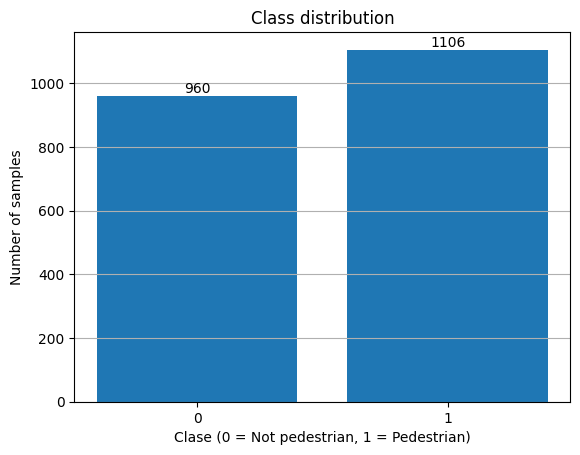

In [11]:
counts = pedestrians_df["label"].value_counts().sort_index()

plt.bar([0, 1], counts.values)
plt.xticks([0, 1])
plt.xlabel("Clase (0 = Not pedestrian, 1 = Pedestrian)")
plt.ylabel("Number of samples")
plt.title("Class distribution")
plt.grid(axis='y')

for i, v in enumerate(counts.values):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.show()

# Show a sample of pedestrian images

In [12]:
# sample of 10 rows
random_pedestrians = pedestrians_df.sample(n=10)
# show the 5 rows
random_pedestrians.head()

,filename,label,features
828,/content/self_driving_car/data/pedestrians/pro...,1,"[0.2318582572222867, 0.2318582572222867, 0.231..."
493,/content/self_driving_car/data/pedestrians/pro...,1,"[0.22688787072286404, 0.13794059341273388, 0.0..."
980,/content/self_driving_car/data/pedestrians/pro...,0,"[0.027486676385498357, 0.03282656801901818, 0...."
967,/content/self_driving_car/data/pedestrians/pro...,0,"[0.04281225048163708, 0.006913033574184006, 0...."
428,/content/self_driving_car/data/pedestrians/pro...,1,"[0.23032147338338205, 0.0850657472752951, 0.24..."


In [13]:
# get the file path image of sample
tmp_pedestrian_path_imgs= random_pedestrians.get("filename").to_list()
# a variable to specify if the image is a pedestrian or not
tmp_pedestrian_labels = random_pedestrians.get("label").apply(lambda x: "Pedestrian" if x == 1 else "Not pedestrian").to_list()

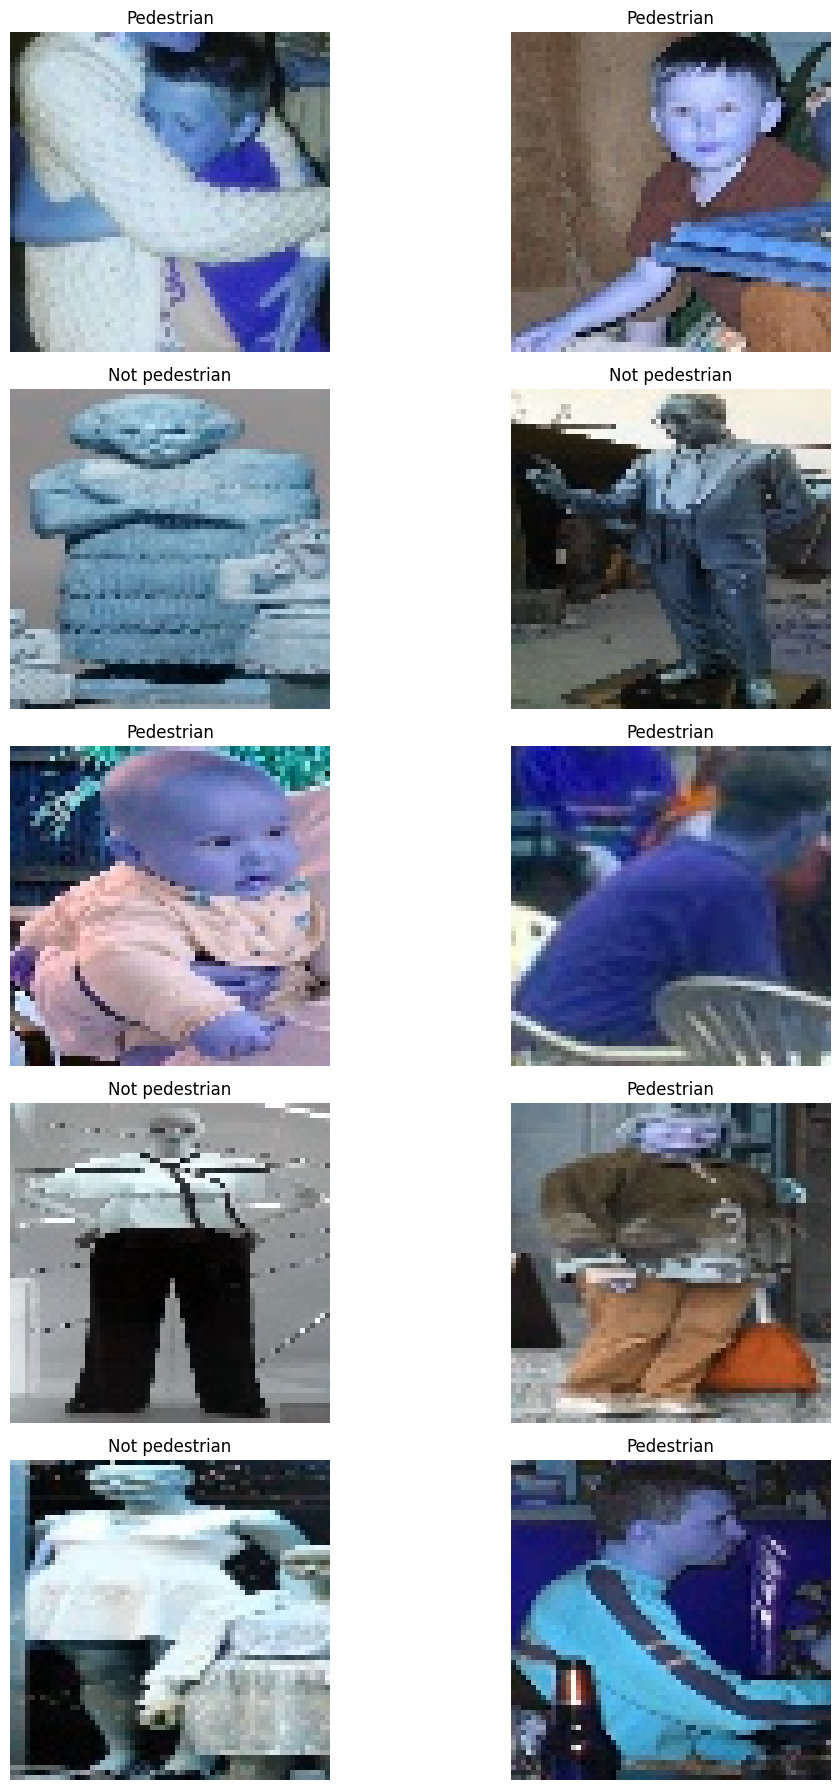

In [14]:
# with utils read_images method, get an array of images gotten in sample dataset
tmp_pedestrian_imgs = utils.read_images(path_images=tmp_pedestrian_path_imgs)
# with utils plot_images method, plot the images gotten in sample dataset
utils.plot_images(images=tmp_pedestrian_imgs, labels=tmp_pedestrian_labels, nrows=nrows, ncols=ncols, figsize=figsize)

# X and Y dataset

In [15]:
# Extract the list of HOG feature vectors from the 'features' column
X = pedestrians_df["features"].tolist()
# Extract the list of labels from the 'label' column and convert it to a NumPy array
y = np.array(pedestrians_df["label"].tolist())
# Stack the list of feature vectors into a single NumPy array (2D matrix)
# and ensure the data type is float64 for numerical processing
X = np.vstack(X).astype(np.float64)
# Extract the list of image file paths or identifiers from the 'filename' column
image_ids = pedestrians_df["filename"].tolist()

In [16]:
# Print the shape of the feature matrix (number of samples, number of features)
print(X.shape)
# Print the shape of the label array (number of labels)
print(y.shape)
# Print the total number of image identifiers (should match number of samples)
print(len(image_ids))

(2066, 396)
(2066,)
2066


# Generate the training and testing data

In [17]:
#Split the dataset into training and testing sets
# 70% of the data will be used for training, and 30% for testing
# The split is done in a stratified and reproducible way using random_state=42
X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(
    X, # HOG feature vectors
    y, # Labels
    image_ids, # Image identifiers
    test_size = 0.3, # 30% of the data for testing
    random_state = 42 # Ensures reproducibility
)

In [18]:
# Display the shape of the training feature matrix
X_train.shape

(1446, 396)

In [19]:
# Display the shape of the testing feature matrix
X_test.shape

(620, 396)

# NNet to classify pedestrians

## HOG Image

In [ ]:
# Load the preprocessed dataset containing HOG features using pandas' pickle loader
feature_len = pedestrians_df["features"].apply(len)
print(f" HOG FEATURE DIMENSION {len(pedestrians_df.loc[0, 'features'])}")

 HOG FEATURE DIMENSION 396


## Normalization

In [20]:
# Create and adapt normalization layer
normalizer = Normalization()
normalizer.adapt(X_train)

## MODEL - MLP



In [49]:
model = Sequential([
    Input(shape=(X.shape[1],)),  # input dimension = num_features (396)
    normalizer,
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 396)            │           793 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │       101,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 143,642 (561.11 KB)

 Trainable params: 142,849 (558.00 KB)

 Non-trainable params: 793 (3.10 KB)

In [65]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=12, batch_size=32, validation_split=0.2)

Epoch 1/12
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9057 - loss: 0.5058 - val_accuracy: 0.6828 - val_loss: 0.9941
Epoch 2/12
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8921 - loss: 0.2558 - val_accuracy: 0.6862 - val_loss: 0.7643
Epoch 3/12
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9244 - loss: 0.2069 - val_accuracy: 0.6897 - val_loss: 0.7861
Epoch 4/12
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9454 - loss: 0.1403 - val_accuracy: 0.6897 - val_loss: 0.8462
Epoch 5/12
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9448 - loss: 0.1638 - val_accuracy: 0.6966 - val_loss: 0.9145
Epoch 6/12
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9384 - loss: 0.1644 - val_accuracy: 0.7000 - val_loss: 0.9760
Epoch 7/12
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9535 - loss: 0.1261 - val_accuracy: 0.6931 - val_loss: 1.0438
Epoch 8/12
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9691 - loss: 0.1109 - val_accuracy: 0.6759 - val_loss

In [66]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7388 - loss: 0.9914
Test loss: 0.9156663417816162
Test accuracy: 0.75


Text(0.5, 0, 'epoch')

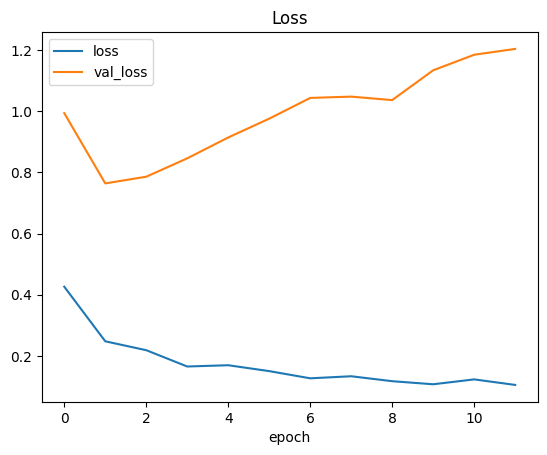

In [67]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

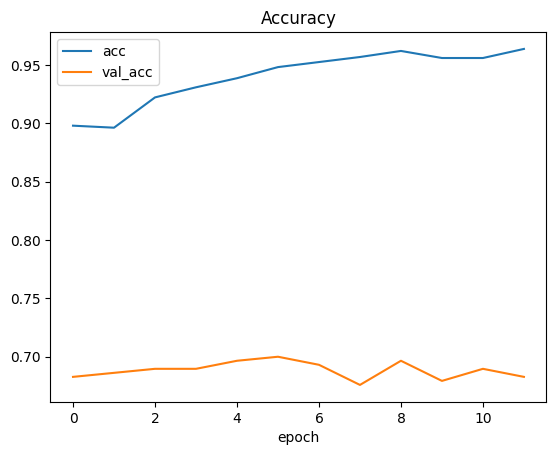

In [68]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['acc', 'val_acc'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [69]:
y_pred = model.predict(X_test) > 0.5
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
              precision    recall  f1-score   support

           0       0.74      0.70      0.72       282
           1       0.76      0.79      0.78       338

    accuracy                           0.75       620
   macro avg       0.75      0.75      0.75       620
weighted avg       0.75      0.75      0.75       620



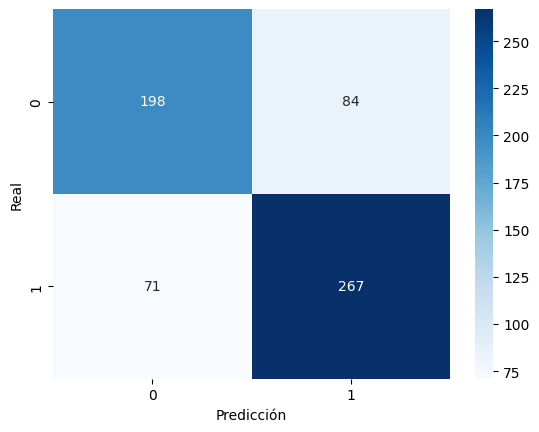

In [70]:
# Heatmap simple
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

In [71]:
pred_probs = model.predict(X_test)
pred_classes = (pred_probs > 0.5).astype("int32")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


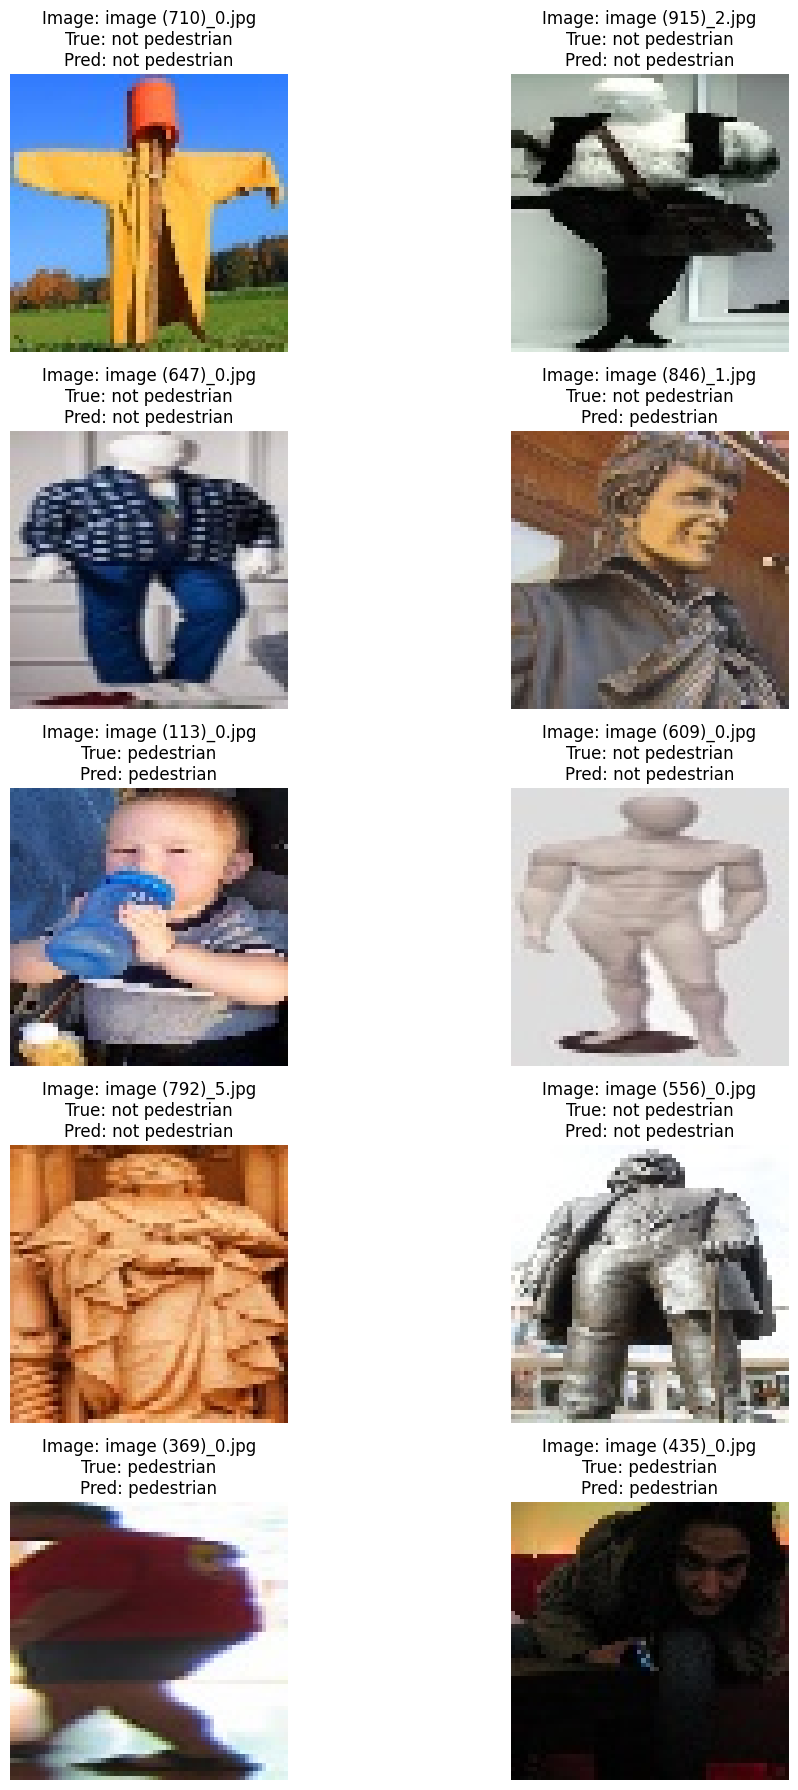

In [72]:
utils.show_predictions(image_ids=id_test, y_true= y_test, y_pred=pred_classes, nrows=nrows, ncols=ncols, figsize=figsize)

## MODEL - CNN

In [73]:
data = []

for file_path in pedestrians_df["filename"].tolist():
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img.astype("float32") / 255.0
    data.append(img)

X = np.array(data)
y = np.array(pedestrians_df["label"].tolist())

In [74]:
X.shape

(2066, 64, 64)

In [75]:
#Split the dataset into training and testing sets
# 70% of the data will be used for training, and 30% for testing
# The split is done in a stratified and reproducible way using random_state=42
X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(
    X, # HOG feature vectors
    y, # Labels
    image_ids, # Image identifiers
    test_size = 0.3, # 30% of the data for testing
    random_state = 42 # Ensures reproducibility
)

In [122]:
model = Sequential([
    Input(shape=(64, 64, 1)),  # 1 canal para escala de grises
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # salida binaria
])
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,624,705 (6.20 MB)

 Trainable params: 1,624,705 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [123]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 374ms/step - accuracy: 0.5037 - loss: 0.7353 - val_accuracy: 0.4793 - val_loss: 0.6966
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5565 - loss: 0.6905 - val_accuracy: 0.6069 - val_loss: 0.6873
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7028 - loss: 0.6759 - val_accuracy: 0.5310 - val_loss: 0.6749
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5697 - loss: 0.6709 - val_accuracy: 0.5724 - val_loss: 0.6558
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6578 - loss: 0.6109 - val_accuracy: 0.6621 - val_loss: 0.6334
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7117 - loss: 0.5562 - val_accuracy: 0.7759 - val_loss: 0.5408
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7418 - loss: 0.5169 - val_accuracy: 0.7241 - val_loss: 0.5755
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7264 - loss: 0.5221 - val_accuracy: 0.7207 - 

In [124]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7981 - loss: 0.4561
Test loss: 0.45378875732421875
Test accuracy: 0.7903226017951965


Text(0.5, 0, 'epoch')

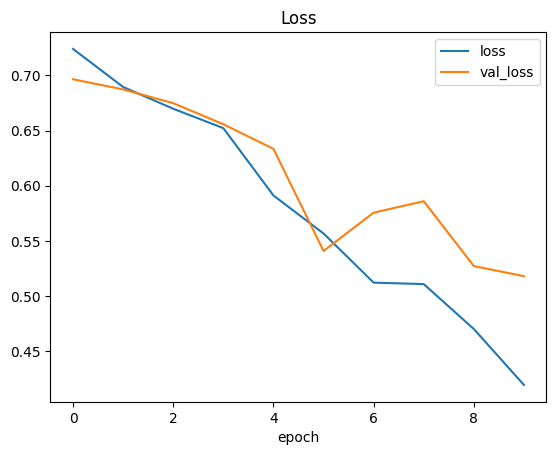

In [125]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

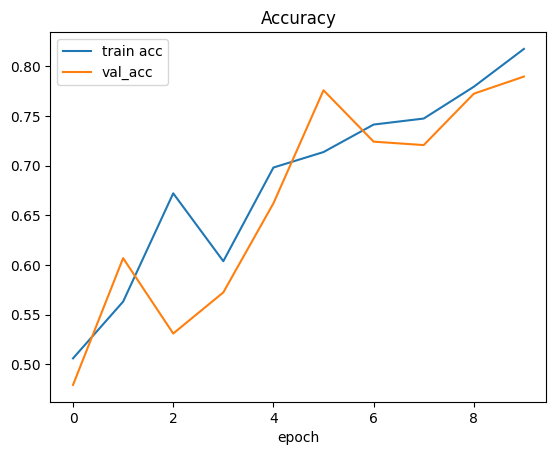

In [126]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train acc', 'val_acc'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [127]:
y_pred = model.predict(X_test) > 0.5
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
              precision    recall  f1-score   support

           0       0.73      0.86      0.79       282
           1       0.86      0.73      0.79       338

    accuracy                           0.79       620
   macro avg       0.80      0.80      0.79       620
weighted avg       0.80      0.79      0.79       620



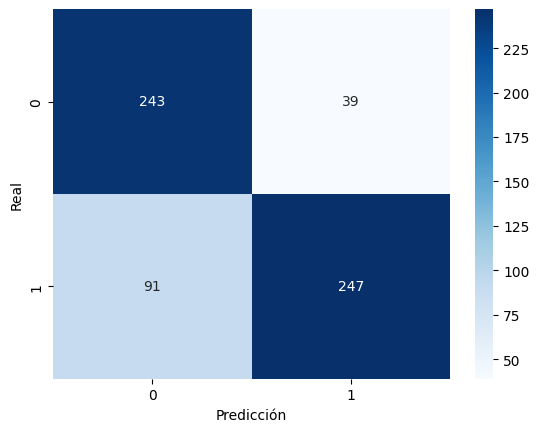

In [128]:
# Heatmap simple
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

In [129]:
pred_probs = model.predict(X_test)
pred_classes = (pred_probs > 0.5).astype("int32")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


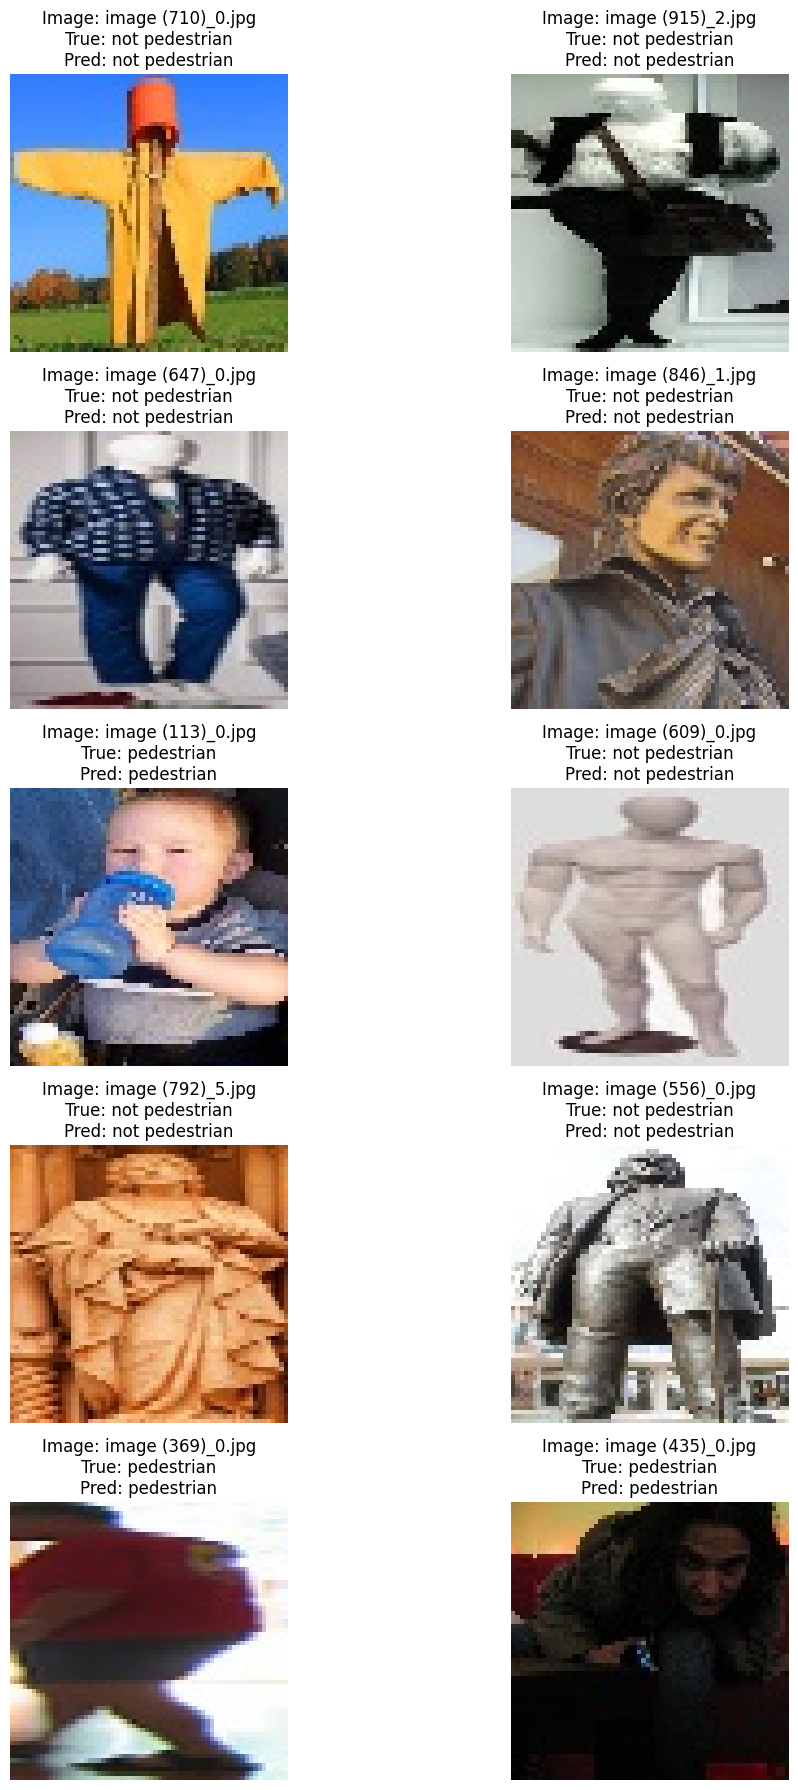

In [130]:
utils.show_predictions(image_ids=id_test, y_true= y_test, y_pred=pred_classes, nrows=nrows, ncols=ncols, figsize=figsize)